In [1]:
# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
print('Number of GPUs available :', len(gpus))
if gpus:
    gpu_num = 0 # Number of the GPU to be used
    try:
        tf.config.set_visible_devices(gpus[gpu_num], 'GPU')
        print('Only GPU number', gpu_num, 'used.')
        tf.config.experimental.set_memory_growth(gpus[gpu_num], True)
    except RuntimeError as e:
        print(e)
!nvidia-smi

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time
import pickle

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna

from tensorflow.keras import Model
from tensorflow.keras.layers import Layer, Conv2D, LayerNormalization
from tensorflow.nn import relu

from sionna.phy.mimo import StreamManagement

#from sionna.phy.ofdm import CSIGridMapper
from sionna.phy.ofdm import ResourceGrid, ResourceGridMapper, ResourceGridDemapper, LSChannelEstimator, LMMSEEqualizer
from sionna.phy.ofdm import OFDMModulator, OFDMDemodulator, RemoveNulledSubcarriers, ZFEqualizer

from sionna.phy.channel.tr38901 import Antenna, AntennaArray, CDL, UMi, UMa, RMa
from sionna.phy.channel import gen_single_sector_topology as gen_topology
from sionna.phy.channel import subcarrier_frequencies, cir_to_ofdm_channel, cir_to_time_channel
from sionna.phy.channel import ApplyOFDMChannel, ApplyTimeChannel, OFDMChannel

from sionna.phy.fec.ldpc.encoding import LDPC5GEncoder
from sionna.phy.fec.ldpc.decoding import LDPC5GDecoder

from sionna.phy.mapping import Mapper, Demapper, BinarySource, QAMSource

from sionna.phy.utils import ebnodb2no, sim_ber
from sionna.phy.utils.metrics import compute_ber
# from sionna.ofdm import CSIGridMapper

2025-08-21 03:43:08.584469: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-21 03:43:08.593662: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755765788.604351 1064722 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755765788.607377 1064722 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755765788.615256 1064722 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Number of GPUs available : 1
Only GPU number 0 used.
Thu Aug 21 03:43:10 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.107.02             Driver Version: 550.107.02     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4080 ...    Off |   00000000:01:00.0 Off |                  N/A |
| N/A   51C    P8              4W /  125W |    7569MiB /  12282MiB |      0%      Default |
|                                         |                        |                  N

## PHY Configurations

Tx_Power: 0.17728766960431616
Noise: -120.22878745280337


I0000 00:00:1755765811.333069 1064722 gpu_process_state.cc:208] Using CUDA malloc Async allocator for GPU: 0
I0000 00:00:1755765811.333452 1064722 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2711 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9
I0000 00:00:1755765814.622467 1064722 cuda_solvers.cc:175] Creating GpuSolver handles for stream 0x609262d84170


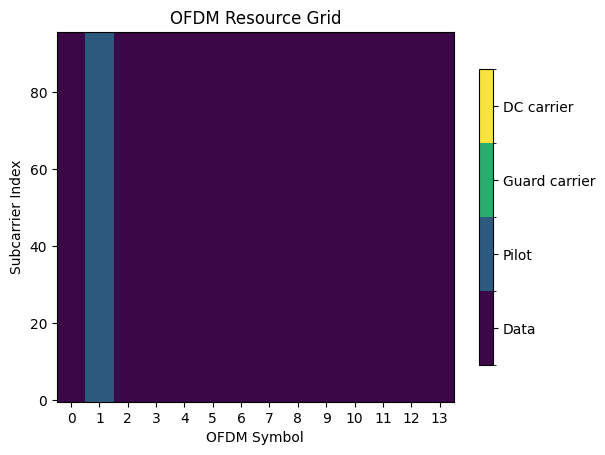

In [2]:
scenario = "umi"
carrier_frequency = 5.3e9
direction = "uplink"
num_ut = 1
batch_size = 10000

num_RB   = 8
num_symbols = 14
num_SC = 96
fft_size = 12*num_RB
subcarrier_spacing = 30e3

## Tx Power
TxPower_dBm     = 20 # in dBm
TxPower         = 10**((TxPower_dBm-30)/10)
TxPower_SC      = TxPower/(num_SC)
TxPower_SC_dBm  = 10*np.log10(TxPower_SC*1000)

# Noise Power
noise_psd       = -174                                  # in dBm/Hz
noise_figure    = 9                                     # in dB
noise_SC_Watt   = 10**((noise_psd + noise_figure - 30)/10)*subcarrier_spacing
noise_SC_dBm    = 10*np.log10(noise_SC_Watt*1000)

print("Tx_Power:",TxPower_SC_dBm)
print("Noise:",noise_SC_dBm)

tf.random.set_seed(1)
# Define the UT antenna array
ut_array = Antenna(polarization="single",
                   polarization_type="V",
                   antenna_pattern="omni",
                   carrier_frequency=carrier_frequency)

# Define the BS antenna array
bs_array = AntennaArray(num_rows=1,
                             num_cols=1, # We want to transmitter to be equiped with the 16 rx antennas
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             polarization_type="V",
                             antenna_pattern="omni",
                             polarization="single",
                             carrier_frequency=5.3e9)

# Create channel model
channel_model = UMi(carrier_frequency=carrier_frequency,
                    o2i_model="low",
                    ut_array=ut_array,
                    bs_array=bs_array,
                    direction=direction,
                    enable_pathloss=True,
                    enable_shadow_fading=True)

# Generate the topology
ut_dist = 10
topology = gen_topology(batch_size, num_ut, scenario,min_bs_ut_dist=ut_dist, min_ut_velocity=0.33, max_ut_velocity=0.33,indoor_probability=0)

# Set the topology
channel_model.set_topology(*topology)
ut_loc = topology[0]
bs_loc = topology[1]
ut_vel = topology[4]

# The number of transmitted streams is equal to the number of UT antennas
num_streams_per_tx = 1

# Create an RX-TX association matrix
# rx_tx_association[i,j]=1 means that receiver i gets at least one stream
# from transmitter j. Depending on the transmission direction (uplink or downlink),
# the role of UT and BS can change. However, as we have only a single
# transmitter and receiver, this does not matter:
rx_tx_association = np.zeros([1, num_ut])
rx_tx_association[:, 0] = 1
#rx_tx_association[:, 1] = 1

# Instantiate a StreamManagement object
# This determines which data streams are determined for which receiver.
# In this simple setup, this is fairly simple. However, it can get complicated
# for simulations with many transmitters and receivers.
sm = StreamManagement(rx_tx_association, num_streams_per_tx)

rg = ResourceGrid(num_ofdm_symbols=14,
                  fft_size=fft_size,
                  subcarrier_spacing=subcarrier_spacing,
                  num_tx=num_ut,
                  num_streams_per_tx=num_streams_per_tx,
                  cyclic_prefix_length=0,
                  pilot_pattern = "kronecker",
                  pilot_ofdm_symbol_indices = [1])
rg.show();

## Classical Communication Blocks

In [3]:
num_bits_per_symbol = 2 # QPSK modulation
coderate = 0.3 # The code rate
n = int(rg.num_data_symbols*num_bits_per_symbol)  # Number of coded bits
k = int(n*coderate) # Number of information bits

# The binary source will create batches of information bits
binary_source = BinarySource()
qam_source = QAMSource(num_bits_per_symbol)

# The encoder maps information bits to coded bits
#encoder = LDPC5GEncoder(k, n)

# The mapper maps blocks of information bits to constellation symbols
mapper = Mapper("qam", num_bits_per_symbol)

# The resource grid mapper maps symbols onto an OFDM resource grid
rg_mapper = ResourceGridMapper(rg)

# CSI-RS mapper
#csi_mapper = CSIGridMapper(rg)

#rg_demap = ResourceGridDemapper(rg, sm)

# This function removes nulled subcarriers from any tensor having the shape of a resource grid
remove_nulled_scs = RemoveNulledSubcarriers(rg)
# The LS channel estimator will provide channel estimates and error variances
ls_est = LSChannelEstimator(rg, interpolation_type="nn")

# CSI-RS estimator will provide the raw channel estimates
#csi_est = CSIrsChannelEstimator(rg, sm)
#csi_est = CSIrsChannelEstimator(rg, sm, TxPower_SC, interpolation_type = 'lin')

# The LMMSE equalizer will provide soft symbols together with noise variance estimates
zf_equ = ZFEqualizer(rg, sm)

# The demapper produces LLR for all coded bits
demapper = Demapper("app", "qam", num_bits_per_symbol)

# The decoder provides hard-decisions on the information bits
#decoder = LDPC5GDecoder(encoder, hard_out=True)

# OFDM CHannel
ofdm_channel = OFDMChannel(channel_model, rg, add_awgn=True, normalize_channel=False, return_channel=True)
channel_freq = ApplyOFDMChannel(add_awgn=True)
frequencies = subcarrier_frequencies(rg.fft_size, rg.subcarrier_spacing)



## Executing Classical Communication System

In [4]:
tf.random.set_seed(42)

# --------- Transmitter ---------
b = binary_source([batch_size, num_ut, rg.num_streams_per_tx, n])  # n must equal (#data_REs * bits_per_sym)
# c = encoder(b)  # keep commented for uncoded link

x = mapper(b)
x_map    = np.sqrt(TxPower_SC) * x                  # map bits -> constellation symbols
x_rg = rg_mapper(x_map)              # map to OFDM resource grid (data REs only)

# --------- Channel ---------
a, tau = channel_model(num_time_samples=rg.num_ofdm_symbols,
                       sampling_frequency=1/rg.ofdm_symbol_duration)
h_freq = cir_to_ofdm_channel(frequencies, a, tau, normalize=False)

# --------- Receive ---------
no = noise_SC_Watt
y  = channel_freq(x_rg, h_freq, no)
print("Received Signal Shape:", y.shape)  # e.g., (N,1,1,S,F)
print("Received Power : ", tf.reduce_mean(tf.abs(y)**2))

# Channel estimation 
'''noise_power = 0.001 * np.mean(np.abs(h_freq)**2)
noise = (np.random.randn(*h_freq.shape) + 1j * np.random.randn(*h_freq.shape)) / np.sqrt(2)
h_freq_d_DL_hat  = h_freq + noise * np.sqrt(noise_power)'''

h_freq_d_DL_hat, _ = ls_est (y, no)
# ZF equalization
x_hat, no_eff = zf_equ(y, h_freq_d_DL_hat, tf.zeros_like(h_freq_d_DL_hat), no)
x_hat = x_hat / np.sqrt(TxPower_SC)

# Demap to bit LLRs for **data REs only**
llr = demapper(x_hat, no_eff)  # shape typically (N, 1, 1, E) or (N,1,1,S,F,B) depending on demapper

# --------- Uncoded hard decisions (NO LDPC decoder here) ---------
# Flatten both LLRs and labels, align lengths, and compute BER
llr_flat = tf.reshape(llr, [tf.shape(llr)[0], -1])              # (N, E)
b_hat    = tf.cast(llr_flat > 0.0, tf.float32)                  # (N, E)

b_flat   = tf.reshape(tf.cast(b, tf.float32), [tf.shape(b)[0], -1])  # (N, n)

# Align in case shapes differ by a few bits (shouldn't if n = #data_REs * B)
T_pred = tf.shape(b_hat)[1]
T_true = tf.shape(b_flat)[1]
T_min  = tf.minimum(T_pred, T_true)
b_hat  = b_hat[:, :T_min]
b_flat = b_flat[:, :T_min]

# --------- Metrics ---------
mse = tf.reduce_mean(tf.abs(h_freq_d_DL_hat - h_freq)**2)
nmse = mse / (tf.reduce_mean(tf.abs(h_freq)**2) + 1e-12)
print("CSI Est NMSE :", nmse.numpy())

ber = compute_ber(b_flat, b_hat).numpy()
print("BER:", ber)


Received Signal Shape: (10000, 1, 1, 14, 96)
Received Power :  tf.Tensor(2.5731547e-10, shape=(), dtype=float32)
Received Pilot Pattern Power :  tf.Tensor(3.5542744e-09, shape=(), dtype=float32)
Pilot Pattern Power :  tf.Tensor(0.9999998, shape=(), dtype=float32)
CSI Est NMSE : 2.9604811e-05
BER: 0.03083477564102564


## Preprocessing Data for NeuralRx

In [5]:
# ----------------------------
# Prepare model inputs with SAME shapes you’ve been using
#   - input_y : (B,1,S,F) complex64
#   - input_h : (B,1,S,F) complex64
#   - input_p : (B,1,S,F) complex64
# ----------------------------
# y is already (B,1,1,S,F) -> squeeze stream axis to get (B,1,S,F)
tf.random.set_seed(42)

# ----------------------------
# Short-hands for dims
# ----------------------------
S = rg.num_ofdm_symbols  # 14
F = num_SC               # 96  (active SC count used by your RG)
B = batch_size

y_data = tf.squeeze(y, axis=2)

# h_freq is (B,1,1,1,1,S,F); remove antenna dims -> (B,S,F), then add channel dim -> (B,1,S,F)
h_tmp  = tf.squeeze(h_freq_d_DL_hat, axis=[1,2,3,4])                              # (B,S,F)
h_data = tf.expand_dims(h_tmp, axis=1)                                    # (B,1,S,F)

# ----------------------------
# Labels for training the NN receiver (same as before)
# ----------------------------
# If your loss expects flattened bits: (B,1,1,-1)
llr_probs = tf.sigmoid(llr)
llr_probs = tf.reshape(llr_probs, [B, 1, 1, -1])

# Quick sanity checks
print("y_data  :", y_data.shape, y_data.dtype)   # (B,1,S,F) complex64
print("h_data  :", h_data.shape, h_data.dtype)   # (B,1,S,F) complex64
print("llr_probs:", llr_probs.shape, llr_probs.dtype)


y_data  : (10000, 1, 14, 96) <dtype: 'complex64'>
h_data  : (10000, 1, 14, 96) <dtype: 'complex64'>
llr_probs: (10000, 1, 1, 2496) <dtype: 'float32'>


## Custom Neural Rx : Divya's Version (Removed Pilots from Input)

In [9]:
import math
import tensorflow as tf
from tensorflow.keras import Model, regularizers
from tensorflow.keras.layers import Layer, LayerNormalization, Dropout, Conv2D, DepthwiseConv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.nn import relu

num_conv_channels = 128

# =========================
# Helper: dataset split
# =========================
def ensure_split(y_data, h_data, llr_probs, batch_size=32):
    # If split already exists, reuse it
    g = globals()
    if 'train_indices' in g and 'val_indices' in g:
        ti, vi = g['train_indices'], g['val_indices']
    else:
        dataset_size = y_data.shape[0]
        idx = tf.random.shuffle(tf.range(dataset_size))
        train_sz = int(0.8 * dataset_size)
        ti, vi = idx[:train_sz], idx[train_sz:]
        g['train_indices'], g['val_indices'] = ti, vi  # store globally for consistency

    y_train = tf.gather(y_data, ti); y_val = tf.gather(y_data, vi)
    h_train = tf.gather(h_data, ti); h_val = tf.gather(h_data, vi)
    llr_train = tf.gather(llr_probs, ti); llr_val = tf.gather(llr_probs, vi)
    return (y_train, y_val, h_train, h_val, llr_train, llr_val, ti, vi)

# =========================
# Learning-rate schedule
# =========================
class CustomLRSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    """Warmup -> constant -> linear (or quadratic) decay driven by optimizer iterations."""
    def __init__(self, min_learning_rate, max_learning_rate, iter_limits, quad_decay=False):
        super().__init__()
        self.quad_decay = quad_decay
        self.min_lr = tf.constant(min_learning_rate, tf.float32)
        self.max_lr = tf.constant(max_learning_rate, tf.float32)
        self.warmup_end = tf.constant(iter_limits[0], tf.float32)
        self.decay_start = tf.constant(iter_limits[1], tf.float32)
        self.last_iter = tf.constant(iter_limits[2], tf.float32)
        if self.quad_decay:
            self.dec_slope = self.max_lr / tf.square(self.last_iter - self.decay_start + 1e-12)
        else:
            self.dec_slope = (self.min_lr - self.max_lr) / (self.last_iter - self.decay_start + 1e-12)

    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        inc_slope = (self.max_lr - self.min_lr) / (self.warmup_end + 1e-12)
        def phase_warmup(): return self.min_lr + step * inc_slope
        def phase_const():  return self.max_lr
        def phase_decay():
            if self.quad_decay:
                return self.dec_slope * tf.square(step - self.last_iter)
            else:
                return self.max_lr + self.dec_slope * (step - self.decay_start)
        def phase_zero():   return tf.constant(0.0, tf.float32)
        return tf.case([
            (step < self.warmup_end, phase_warmup),
            (tf.logical_and(step >= self.warmup_end, step < self.decay_start), phase_const),
            (tf.logical_and(step >= self.decay_start, step < self.last_iter), phase_decay),
        ], default=phase_zero, exclusive=True)

# =========================
# Loss
# =========================
def binary_sigmoid_cross_entropy(bit_labels, pred_llr):
    
    bit_labels = tf.cast(bit_labels, pred_llr.dtype)
    valid_mask = tf.not_equal(bit_labels, -1)
    bit_prob = tf.sigmoid(pred_llr)
    bit_prob_masked = tf.boolean_mask(bit_prob, valid_mask)
    bit_labels_masked = tf.boolean_mask(bit_labels, valid_mask)
    bce = tf.keras.losses.binary_crossentropy(bit_labels_masked, bit_prob_masked)
    return tf.reduce_mean(bce)

# =========================
# Depthwise residual block
# =========================
class DWResidualBlock(Layer):
    def __init__(self, dropout_rate=0.10, **kwargs):
        super().__init__(**kwargs)
        self.dropout_rate = dropout_rate
        self.reg = regularizers.l2(1e-5)

    def build(self, input_shape):
        c = int(input_shape[-1])
        self.ln1  = LayerNormalization(axis=(-1, -2, -3))
        self.dw1  = DepthwiseConv2D(kernel_size=3, padding='same',
                                    activation=None, depth_multiplier=1,
                                    depthwise_regularizer=self.reg)
        self.pw1  = Conv2D(filters=c, kernel_size=1, padding='same',
                           activation=None, kernel_regularizer=self.reg)
        self.drop1 = Dropout(self.dropout_rate)

        self.ln2  = LayerNormalization(axis=(-1, -2, -3))
        self.dw2  = DepthwiseConv2D(kernel_size=3, padding='same',
                                    activation=None, depth_multiplier=1,
                                    depthwise_regularizer=self.reg)
        self.pw2  = Conv2D(filters=c, kernel_size=1, padding='same',
                           activation=None, kernel_regularizer=self.reg)
        self.drop2 = Dropout(self.dropout_rate)

    def call(self, x, training=False):
        z = self.ln1(x);  z = relu(z)
        z = self.dw1(z);  z = self.pw1(z)
        z = self.drop1(z, training=training)

        z = self.ln2(z);  z = relu(z)
        z = self.dw2(z);  z = self.pw2(z)
        z = self.drop2(z, training=training)

        return x + z

# =========================
# Neural Receiver (3 inputs): y, h, p
# =========================
class NeuralReceiver(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.reg = regularizers.l2(1e-5)

    def build(self, input_shape):
        self.input_conv  = Conv2D(filters=num_conv_channels, kernel_size=3, padding='same',
                                  activation=None, kernel_regularizer=self.reg)
        self.res1 = DWResidualBlock(0.10)
        self.res2 = DWResidualBlock(0.10)
        self.res3 = DWResidualBlock(0.10)
        self.res4 = DWResidualBlock(0.10)
        self.output_conv = Conv2D(filters=num_bits_per_symbol, kernel_size=3, padding='same',
                                  activation=None, kernel_regularizer=self.reg)

    def call(self, inputs, training=False):
        # Inputs: (B,1,S,F) complex64
        y, h = inputs
        batch_size = tf.shape(y)[0]

        # (B,1,S,F) -> (B,S,F,1)
        y = tf.transpose(y, [0, 2, 3, 1])
        h = tf.transpose(h, [0, 2, 3, 1])

        # Per-sample power normalization
        def norm_per_sample(t):
            pow_t = tf.reduce_mean(tf.abs(t), axis=[1,2,3], keepdims=True) + 1e-6
            return t / tf.cast(pow_t, t.dtype)

        y_n = norm_per_sample(y)
        h_n = norm_per_sample(h)

        # RI concat -> (B,S,F,6)
        y_ri = tf.concat([tf.math.real(y_n), tf.math.imag(y_n)], axis=-1)
        h_ri = tf.concat([tf.math.real(h_n), tf.math.imag(h_n)], axis=-1)

        z = tf.concat([y_ri, h_ri], axis=-1)

        # Backbone
        z = self.input_conv(z)
        z = self.res1(z, training=training)
        z = self.res2(z, training=training)
        z = self.res3(z, training=training)
        z = self.res4(z, training=training)
        z = self.output_conv(z)  # (B,S,F,num_bits_per_symbol)

        # ---- DROP PILOT SYMBOL (index 1) from logits so labels align ----
        # z has S along axis=1: keep [0] and [2..S-1], remove index 1
        z_data = tf.concat([z[:, :1, :, :], z[:, 2:, :, :]], axis=1)  # (B,S-1,F,bits)

        # Flatten -> (B,1,1,(S-1)*F*bits) to match llr labels

        z_flat = tf.reshape(z_data, [batch_size, 1, 1, -1])
        return z_flat


# =========================
# Build model (I/O shapes unchanged)
# =========================
input_y = tf.keras.Input(shape=(1, num_symbols, num_SC), dtype=tf.complex64)
input_h = tf.keras.Input(shape=(1, num_symbols, num_SC), dtype=tf.complex64)

receiver = NeuralReceiver()
output_llrs = receiver([input_y, input_h])
receiver_model = Model(inputs=[input_y, input_h], outputs=output_llrs)

# =========================
# Create pilots p_all (N,1,S,F) complex64, nonzero only at symbol 1
# =========================
# y_data/h_data/llr_probs must already exist at this point
N = int(y_data.shape[0])
S = int(num_symbols); F = int(num_SC)

p_val = tf.complex(tf.constant(1.0, tf.float32), tf.constant(0.0, tf.float32))  # 1+0j
sym1_mask = tf.one_hot(1, depth=S, dtype=tf.float32)       # (S,)
sym1_mask = tf.reshape(sym1_mask, [1,1,S,1])               # (1,1,S,1)

# All subcarriers as pilots on symbol 1 (comb optional below)
#sc_mask = tf.ones([1,1,1,F], tf.float32)                   # (1,1,1,F)
# # Optional comb pilot pattern:
# pilot mask construction (you already have this)
K = 4
comb = tf.cast(tf.equal(tf.range(F) % K, 0), tf.float32)   # (F,)
sc_mask = tf.reshape(comb, [1,1,1,F])                      # (1,1,1,F)

# Apply mask to channel estimates (same shape)
h_masked = h_data * tf.cast(sc_mask, tf.complex64)                             # (N,1,S,F)

y_train, y_val, h_train, h_val, llr_train, llr_val, train_indices, val_indices = ensure_split(
    y_data, h_data, llr_probs, batch_size=32
)

h_train = tf.gather(h_masked, train_indices)
h_val   = tf.gather(h_masked, val_indices)

# =========================
# Compile & Train
# =========================
batch_size = 32
total_epochs = 100
steps_per_epoch = math.ceil(y_train.shape[0] / batch_size)

warmup_epochs = 6
decay_start_epoch = 22
iter_limits = [
    warmup_epochs * steps_per_epoch,
    decay_start_epoch * steps_per_epoch,
    total_epochs * steps_per_epoch
]

lr_schedule = CustomLRSchedule(
    min_learning_rate=0.0,
    max_learning_rate=1e-3,
    iter_limits=iter_limits,
    quad_decay=False
)

receiver_model.compile(
    optimizer=Adam(learning_rate=lr_schedule),
    loss=binary_sigmoid_cross_entropy
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=6, restore_best_weights=True, min_delta=1e-4
)

history = receiver_model.fit(
    [y_train, h_train],
    llr_train,
    validation_data=([y_val, h_val], llr_val),
    batch_size=batch_size,
    epochs=total_epochs,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100


I0000 00:00:1755765933.990245 1068720 service.cc:152] XLA service 0x759c00004fe0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755765933.990287 1068720 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4080 Laptop GPU, Compute Capability 8.9
2025-08-21 03:45:34.189661: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-08-21 03:45:34.352982: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator adam/case/Assert/AssertGuard/Assert
I0000 00:00:1755765935.772283 1068720 cuda_dnn.cc:529] Loaded cuDNN version 90500


 10/250 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.7205

I0000 00:00:1755765943.427105 1068720 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


250/250 ━━━━━━━━━━━━━━━━━━━━ 23s 42ms/step - loss: 0.7123 - val_loss: 0.6846
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.5369 - val_loss: 0.1236
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.1427 - val_loss: 0.0904
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.1053 - val_loss: 0.0769
Epoch 5/100
163/250 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0809

KeyboardInterrupt: 

## Model Evaluation

In [10]:
# ==== Evaluate after training (validation split) ====

# 1) Predict LLRs with the neural receiver  (NOTE: 2 inputs!)
llr_pred = receiver_model.predict([y_val, h_val], batch_size=32, verbose=0)  # (valN, 1, 1, B_data)

# 2) Hard decisions -> predicted bits {0,1}; flatten to (valN, B_data)
bits_pred_flat = tf.reshape(tf.cast(llr_pred > 0.0, tf.float32),
                            [tf.shape(llr_pred)[0], -1])

# 3) Ground-truth bits for the SAME validation subset; flatten to (valN, n_gt_bits)
#    b shape from Tx step: (N, num_ut, rg.num_streams_per_tx, n_data_bits)
b_all_flat = tf.squeeze(b, axis=[1, 2])                              # -> (N, n_data_bits)
b_val_flat = tf.cast(tf.gather(b_all_flat, val_indices), tf.float32) # -> (valN, n_data_bits)

# 4) Align lengths in case model outputs only data REs (e.g., pilot symbol dropped)
pred_len = tf.shape(bits_pred_flat)[1]
gt_len   = tf.shape(b_val_flat)[1]

# If needed, truncate ground-truth to the prediction length (should match already if labels were made data-only)
b_val_flat = b_val_flat[:, :pred_len]

# 5) Neural receiver BER
ber_neural = compute_ber(b_val_flat, bits_pred_flat).numpy()
print(f"Neural Receiver BER (validation): {ber_neural:.6f}")

# ----- Optional: compare with classical ZF baseline on the SAME val split -----
try:
    # If you still have 'llr' from the ZF demapper used earlier:
    # llr shape typically: (N, num_symbols, num_SC, num_bits_per_symbol) or already flattened.
    if len(llr.shape) > 2:
        bits_zf = tf.cast(llr > 0.0, tf.float32)                     # -> (N, ..., ..., ...)
        bits_zf_flat = tf.reshape(bits_zf, [tf.shape(bits_zf)[0], -1])  # -> (N, n_bits_total)
    else:
        bits_zf_flat = tf.cast(llr > 0.0, tf.float32)                # already (N, n_bits_total)

    bits_zf_val_flat = tf.gather(bits_zf_flat, val_indices)          # -> (valN, n_bits_total)

    # Align ZF length with model output (data-only length)
    bits_zf_val_flat = bits_zf_val_flat[:, :pred_len]

    ber_zf = compute_ber(b_val_flat, bits_zf_val_flat).numpy()
    print(f"ZF Baseline BER (validation): {ber_zf:.6f}")
    if ber_zf > 0:
        print(f"Relative BER change vs ZF: {(ber_neural - ber_zf) / ber_zf:+.2%}")
except Exception as e:
    print("ZF baseline comparison skipped (llr not available or shape mismatch).")
    print(f"Reason: {e}")

Neural Receiver BER (validation): 0.033323
ZF Baseline BER (validation): 0.031689
Relative BER change vs ZF: +5.16%


## Candidate 2 : NI's Version of DeepRx (Can Remove Pilots and Try)

In [ ]:
class ResNetBlockProperties:
    """Structure that holds all configurational parameters of the ResNet blocks."""

    num_blocks: int = 0
    kernel_size: list = []
    dilation_rate: list = []
    num_filter: list = []

class DeepRx:
    """DeepRx neural network model"""

    def __init__(
        self,
        num_ofdm_sym: int,
        num_subcar: int,
        num_ant: int,
        res_net_config: ResNetBlockProperties,
        num_output_llr: int,
        use_submodels: bool,
    ):
        """Initializes the network topology"""

        # number of symbols in time: S
        self.num_ofdm_sym = num_ofdm_sym
        # number of subcarriers: F
        self.num_subcar = num_subcar
        # number of antennas: N_r
        self.num_ant = num_ant
        # number of output LLRs: B
        self.num_output_llr = num_output_llr

        # RX data input: complex value already split into two channels
        y = tf.keras.layers.Input(shape=(num_ofdm_sym, num_subcar, 2 * num_ant), name="RX-Data-In")
        # TX pilots: complex value already split into two channels
        x_p = tf.keras.layers.Input(shape=(num_ofdm_sym, num_subcar, 2), name="TX-Pilot-In")
        # raw channel estimate: complex value already split into two channels
        h_r = tf.keras.layers.Input(shape=(num_ofdm_sym, num_subcar, 2 * num_ant), name="Raw-Channel-Est-In")
        # concatenate input layers
        concat = tf.keras.layers.concatenate([y, x_p, h_r], name="Concat")
        # convolutional input layer
        x = tf.keras.layers.Conv2D(64, (3, 3), dilation_rate=(1, 1), padding="same", activation=None, name="Conv-In")(
            concat
        )
        # construct ResNet blocks
        for block_idx in range(res_net_config.num_blocks):
            # generate ResNet block as compact sub-models
            if use_submodels:
                _, res_net_block = self.create_res_net_block(
                    input=x,
                    filter_size=tuple(res_net_config.kernel_size[block_idx]),
                    dilation=tuple(res_net_config.dilation_rate[block_idx]),
                    num_filter=res_net_config.num_filter[block_idx],
                    res_net_block_idx=block_idx,
                )
                x = res_net_block(x)
            # generate ResNet block with all sub-layers visible
            else:
                x, _ = self.create_res_net_block(
                    input=x,
                    filter_size=tuple(res_net_config.kernel_size[block_idx]),
                    dilation=tuple(res_net_config.dilation_rate[block_idx]),
                    num_filter=res_net_config.num_filter[block_idx],
                    res_net_block_idx=block_idx,
                )
        # convolutional output layer: LLR
        output = tf.keras.layers.Conv2D(
            self.num_output_llr, (3, 3), dilation_rate=(1, 1), padding="same", activation=None, name="Conv-Out"
        )(x)
        # instantiate complete model
        self.model = tf.keras.Model(inputs=[y, x_p, h_r], outputs=output, name="DeepRx")

    def create_res_net_block(
        self,
        input: tf.Tensor,
        filter_size: tuple,
        dilation: tuple,
        num_filter: int,
        res_net_block_idx: int,
    ):
        """Creates the ResNet sub-blocks"""
        x = tf.keras.layers.BatchNormalization(name=f"BN-{res_net_block_idx}-0")(input)
        x = tf.keras.layers.ReLU(name=f"ReLU-{res_net_block_idx}-0")(x)
        x = tf.keras.layers.SeparableConv2D(
            filters=num_filter,
            kernel_size=filter_size,
            dilation_rate=dilation,
            depth_multiplier=1,
            padding="same",
            name=f"Separable-Conv-{res_net_block_idx}-0",
        )(x)
        x = tf.keras.layers.BatchNormalization(name=f"BN-{res_net_block_idx}-1")(x)
        x = tf.keras.layers.ReLU(name=f"ReLU-{res_net_block_idx}-1")(x)
        x = tf.keras.layers.SeparableConv2D(
            filters=num_filter,
            kernel_size=filter_size,
            dilation_rate=dilation,
            depth_multiplier=1,
            padding="same",
            name=f"Separable-Conv-{res_net_block_idx}-1",
        )(x)

        # When ResNet block's output depth is increased or decreased, also the residual path has to be up- or downsampled.
        # This can be achieved via 1x1 convolutions.
        if input.shape[3] != num_filter:
            x_shortcut = tf.keras.layers.Conv2D(num_filter, (1, 1), name=f"Conv-Depth-Adjust-{res_net_block_idx}")(
                input
            )
            # TODO: do we need additional BN and ReLU activation here?
            x_shortcut = tf.keras.layers.BatchNormalization(name=f"BN-{res_net_block_idx}-2")(x_shortcut)
            # x_shortcut = tf.keras.layers.ReLU(name=f"ReLU-{res_net_block_idx}-2")(x_shortcut)
        else:
            x_shortcut = input

        output = tf.keras.layers.Add(name=f"Add-{res_net_block_idx}")([x_shortcut, x])

        res_net_model = tf.keras.Model(inputs=input, outputs=output, name=f"ResNet-Block-{res_net_block_idx}")

        return output, res_net_model